In [52]:
from typing import Callable, Any
import glob
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATASET = "adult"
os.makedirs("plots", exist_ok=True)
COV_CUTOFFS = {
    "adult": (80, 95),      # for mixed
    # "adult": (39.5, 80.5), # for ind, sep
    "bank": (39.5, 80.5),
    "compas": (32, 74),
    "default": (39.5, 80.5),
    "german": (39.5, 80.5),
}

In [53]:
formatting = {
    "risan": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN",
        "alpha": 0.4,
    },
    "risan g0": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN group 0",
        "alpha": 0.4,
    },
    "risan g1": {
        "color": "black",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN group 1",
        "alpha": 0.4,
    },
    "eq risan": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN",
        "alpha": 0.4,
    },
    "eq risan g0": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN group 0",
        "alpha": 0.4,
    },
    "eq risan g1": {
        "color": "blue",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE RISAN group 1",
        "alpha": 0.4,
    },

    "kp1": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1",
        "alpha": 0.4,
    },
    "kp1 g0": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 group 0",
        "alpha": 0.4,
    },
    "kp1 g1": {
        "color": "red",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 group 1",
        "alpha": 0.4,
    },
    "eq kp1": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1",
        "alpha": 0.4,
    },
    "eq kp1 g0": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1 group 0",
        "alpha": 0.4,
    },
    "eq kp1 g1": {
        "color": "darkorange",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE KP1 group 1",
        "alpha": 0.4,
    },

    "dpabst": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "dpabst g0": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "dpabst g1": {
        "color": "green",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },
}

In [54]:
def plot_with_std(x_vals: pd.Series, y_vals: pd.Series, y_std: pd.Series, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    fill_kwargs = formatting.copy()
    del fill_kwargs["label"]
    del fill_kwargs["marker"]
    plt.plot(x_vals, y_vals, **plot_kwargs)
    lower = ((y_vals - y_std).to_numpy()).clip(min=0, max=100)
    upper = ((y_vals + y_std).to_numpy()).clip(min=0, max=100)
    plt.fill_between(x_vals, lower, upper, **fill_kwargs)


def plot_without_std(x_vals, y_vals, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    plt.plot(x_vals, y_vals, **plot_kwargs)

def plots(dataframes: dict[str, pd.DataFrame], metric: str, std: bool, groupwise: bool, diff: bool):
    for key in dataframes:
        if dataframes[key].empty:
            continue
        if std:
            if groupwise:
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_0_avg"],
                    dataframes[key][f"{metric}_0_std"],
                    formatting[f"{key} g0"],
                )
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_1_avg"],
                    dataframes[key][f"{metric}_1_std"],
                    formatting[f"{key} g1"],
                )
            else:
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_avg"],
                    dataframes[key][f"{metric}_std"],
                    formatting[f"{key}"],
                )
        else: # Difference plots
            if diff:
                plot_without_std(
                    dataframes[key]["cov_avg"],
                    abs(dataframes[key][f"{metric}_0_avg"] - dataframes[key][f"{metric}_1_avg"]),
                    formatting[f"{key}"],
                )

def print_table(
    dataframes: dict[str, pd.DataFrame], metrics: list[str], agr: Callable[[Any], Any]
):
    entries = {"model": []}
    for metric in metrics:
        entries[metric] = []
    for key in dataframes.keys():
        if dataframes[key].empty:
            continue
        entries["model"].append(key)
        for metric in metrics:
            entries[metric].append(
                np.round(
                    agr(
                        np.abs(
                            dataframes[key][f"{metric}_0_avg"]
                            - dataframes[key][f"{metric}_1_avg"]
                        )
                    ),
                    2,
                )
            )
    df = pd.DataFrame.from_dict(entries)
    print(df)

# Independence section

In [55]:
risan_pd = pd.DataFrame()
eq_risan_pd = pd.DataFrame()
kp1_pd = pd.DataFrame()
eq_kp1_pd = pd.DataFrame()
dpabst_pd = pd.DataFrame()

for file in glob.glob("results/*.json"):
    args = file.split("_")
    dataset = args[0].split("/")[1]
    if dataset != DATASET:
        continue
    model = args[2]
    fairness_conditions = args[1]
    record = {}
    with open(file, "r") as f:
            data = json.load(f)
    for key in data.keys():
        record[f"{key}_avg"] = round(data[key][0], 2)
        record[f"{key}_std"] = round(data[key][1], 2)
    temp = pd.Series(record).to_frame().T

    if model == "dpabst":
        cov = float(args[3].split(".j")[0])*100
        if cov < COV_CUTOFFS[DATASET][0] or cov > COV_CUTOFFS[DATASET][1]:
            continue
        dpabst_pd = pd.concat([dpabst_pd, temp])
    elif fairness_conditions == "none":
        if record["cov_avg"] < COV_CUTOFFS[DATASET][0] or record["cov_avg"] > COV_CUTOFFS[DATASET][1]:
            continue  
        if model == "risan":
            risan_pd = pd.concat([risan_pd, temp])
        else:
            kp1_pd = pd.concat([kp1_pd, temp])
    elif fairness_conditions == "abs-neg-pos":
        if record["cov_avg"] < COV_CUTOFFS[DATASET][0] or record["cov_avg"] > COV_CUTOFFS[DATASET][1]:
            continue  
        if model == "risan":
            eq_risan_pd = pd.concat([eq_risan_pd, temp])
        else:
            eq_kp1_pd = pd.concat([eq_kp1_pd, temp])
    else:
        continue #only normal and independence pd in this cell

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd,
    "eq risan": eq_risan_pd,
    "kp1": kp1_pd,
    "eq kp1": eq_kp1_pd,
    "dpabst": dpabst_pd,
}

for key in list(dataframes.keys()):
    if dataframes[key].empty:
        continue
    dataframes[key] = dataframes[key].sort_values(by="cov_avg")
    last_cov_value = None
    mask = []
    for idx, row in dataframes[key].iterrows():
        if last_cov_value is None or row["cov_avg"] - last_cov_value >= 0.8:
            mask.append(True)
            last_cov_value = row["cov_avg"]
        else:
            mask.append(False)
    dataframes[key] = dataframes[key][mask]

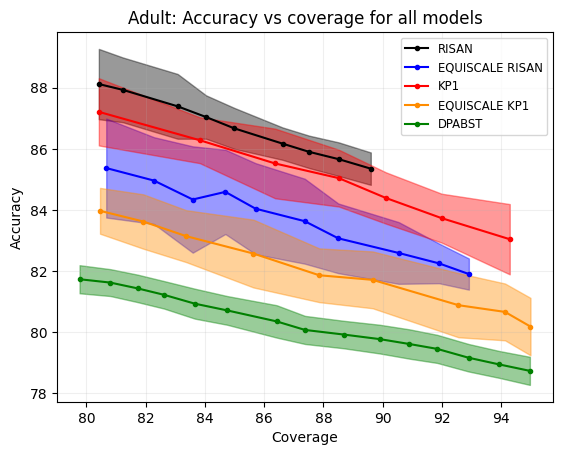

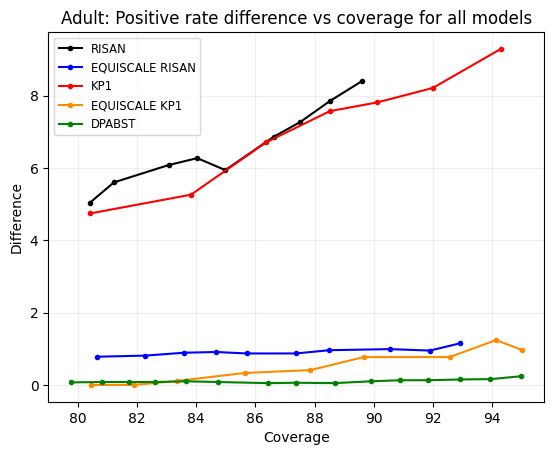

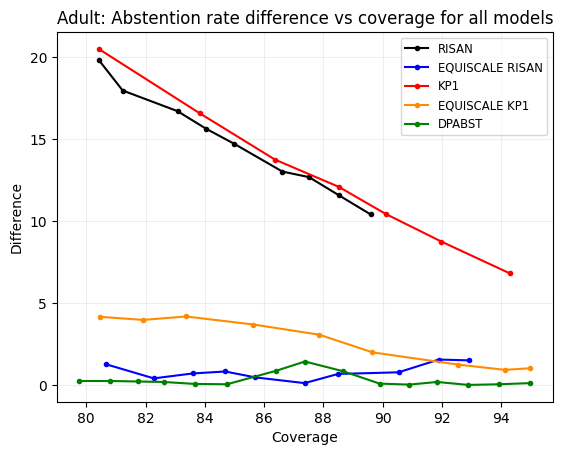

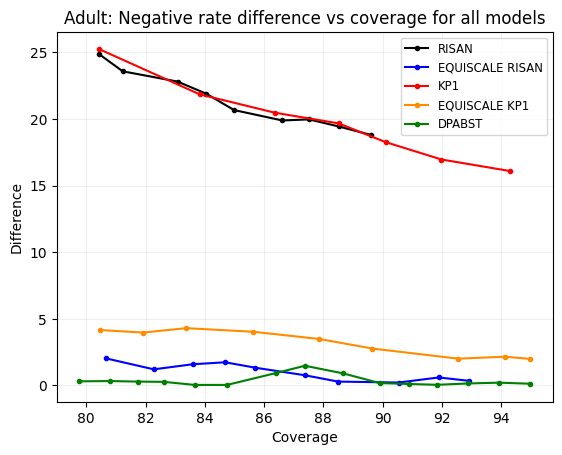

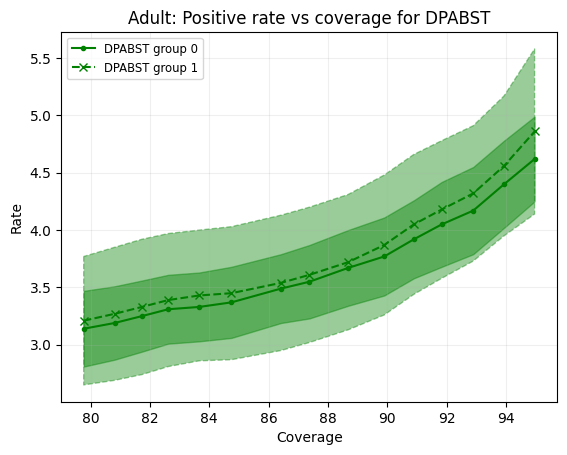

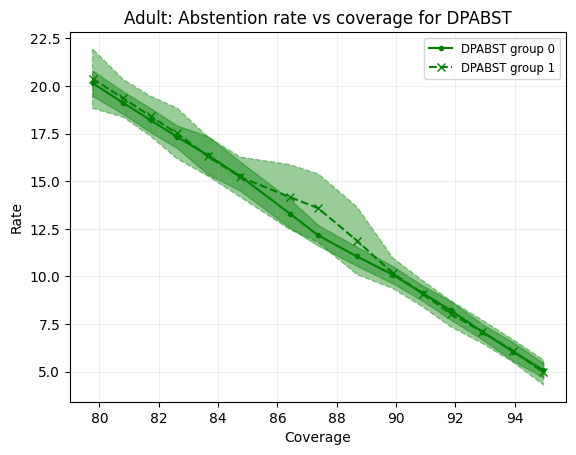

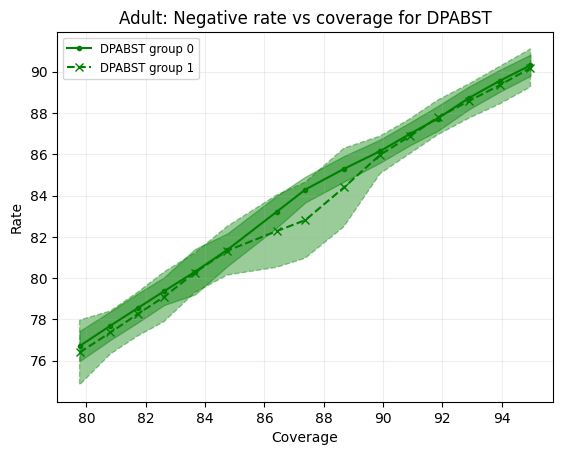

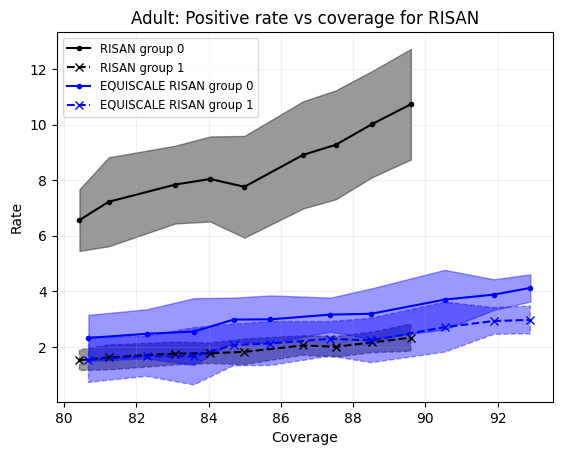

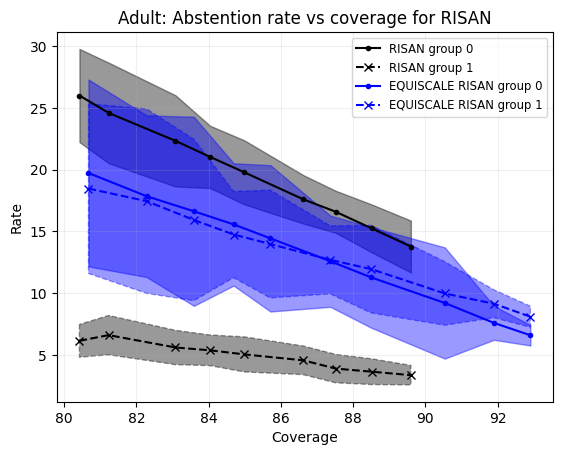

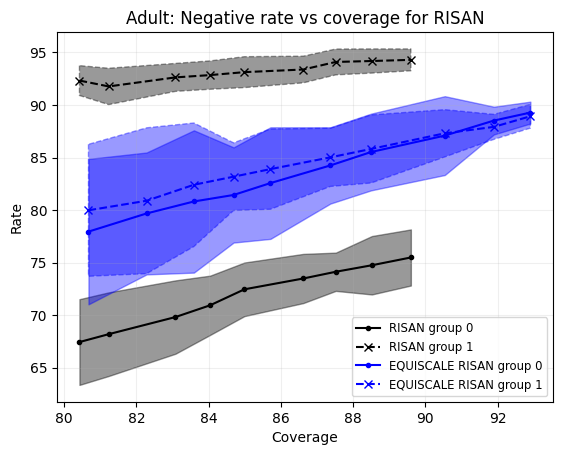

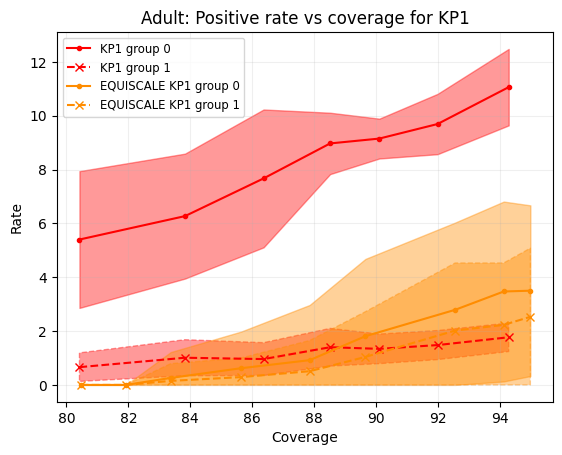

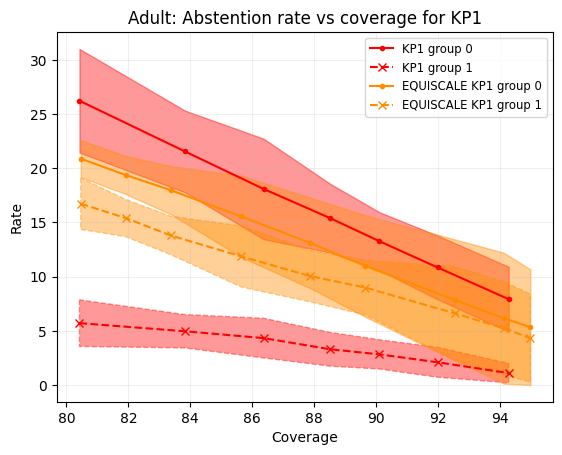

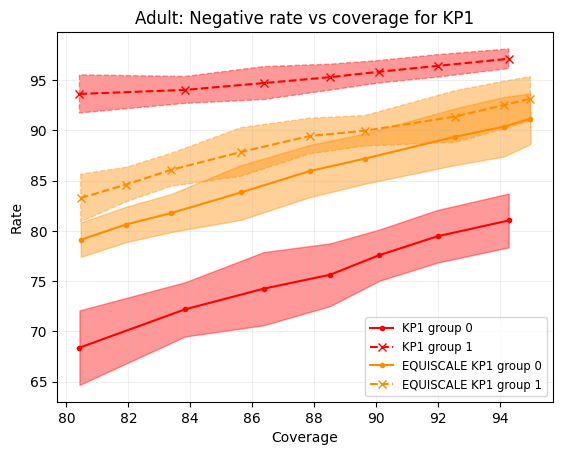

Average violation of fairness constraints
      model   pos    neg    abs
0     risan  6.59  21.33  14.74
1  eq risan  0.92   1.01   0.82
2       kp1  7.08  19.80  12.71
3    eq kp1  0.51   3.21   2.69
4    dpabst  0.10   0.36   0.30
Median violation of fairness constraints
      model   pos    neg    abs
0     risan  6.27  20.67  14.73
1  eq risan  0.90   0.99   0.73
2       kp1  7.57  19.67  12.10
3    eq kp1  0.41   3.49   3.07
4    dpabst  0.08   0.21   0.18
Max violation of fairness constriants
      model   pos    neg    abs
0     risan  8.40  24.89  19.85
1  eq risan  1.15   2.03   1.55
2       kp1  9.29  25.26  20.52
3    eq kp1  1.24   4.30   4.18
4    dpabst  0.24   1.48   1.43


In [56]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_acc")
plt.show()


# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "pos", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_ind_pos")
# plt.show()


# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "abs", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_ind_abs")
# plt.show()


# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "neg", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_ind_neg")
# plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "pos", False, False, True)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_pos_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "abs", False, False, True)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_abs_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "neg", False, False, True)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_neg_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_dpabst_pos")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_dpabst_abs")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_dpabst_neg")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_risan_pos")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_risan_abs")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_risan_neg")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_kp1_pos")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_kp1_abs")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_kp1_neg")
plt.show()

print("Average violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.average)
print("Median violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.median)
print("Max violation of fairness constriants")
print_table(dataframes, ["pos", "neg", "abs"], np.max)

---

# Separation section

In [57]:
# Separation section
risan_pd = pd.DataFrame()
eq_risan_pd = pd.DataFrame()
kp1_pd = pd.DataFrame()
eq_kp1_pd = pd.DataFrame()

for file in glob.glob("results/*.json"):
    args = file.split("_")
    dataset = args[0].split("/")[1]
    if dataset != DATASET:
        continue
    model = args[2]
    fairness_conditions = args[1]
    record = {}
    with open(file, "r") as f:
            data = json.load(f)
    for key in data.keys():
        record[f"{key}_avg"] = round(data[key][0], 2)
        record[f"{key}_std"] = round(data[key][1], 2)
    temp = pd.Series(record).to_frame().T

    if model == "dpabst":
        continue
    elif fairness_conditions == "none":
        if record["cov_avg"] < COV_CUTOFFS[DATASET][0] or record["cov_avg"] > COV_CUTOFFS[DATASET][1]:
            continue  
        if model == "risan":
            risan_pd = pd.concat([risan_pd, temp])
        else:
            kp1_pd = pd.concat([kp1_pd, temp])
    elif fairness_conditions == "fnr-fpr-nar-par-tnr-tpr":
        if record["cov_avg"] < COV_CUTOFFS[DATASET][0] or record["cov_avg"] > COV_CUTOFFS[DATASET][1]:
            continue  
        if model == "risan":
            eq_risan_pd = pd.concat([eq_risan_pd, temp])
        else:
            eq_kp1_pd = pd.concat([eq_kp1_pd, temp])
    else:
        continue #only normal and separation pd in this cell

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd,
    "eq risan": eq_risan_pd,
    "kp1": kp1_pd,
    "eq kp1": eq_kp1_pd,
}

for key in list(dataframes.keys()):
    if dataframes[key].empty:
        continue
    dataframes[key] = dataframes[key].sort_values(by="cov_avg")
    last_cov_value = None
    mask = []
    for idx, row in dataframes[key].iterrows():
        if last_cov_value is None or row["cov_avg"] - last_cov_value >= 0.8:
            mask.append(True)
            last_cov_value = row["cov_avg"]
        else:
            mask.append(False)
    dataframes[key] = dataframes[key][mask]


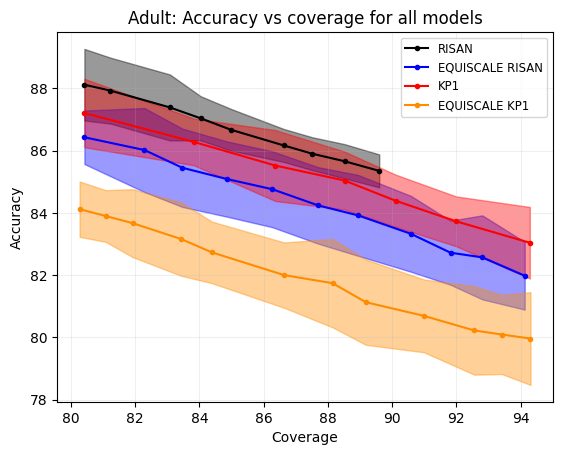

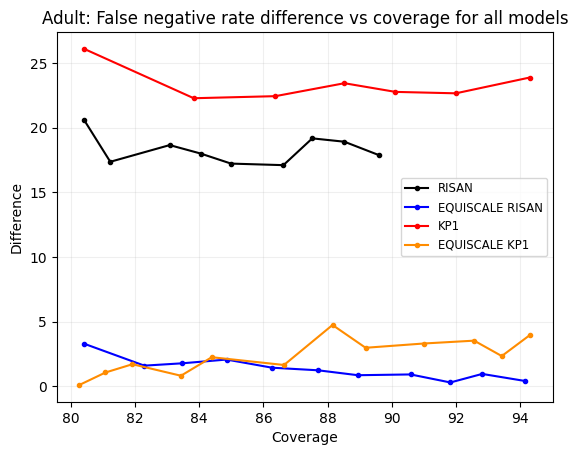

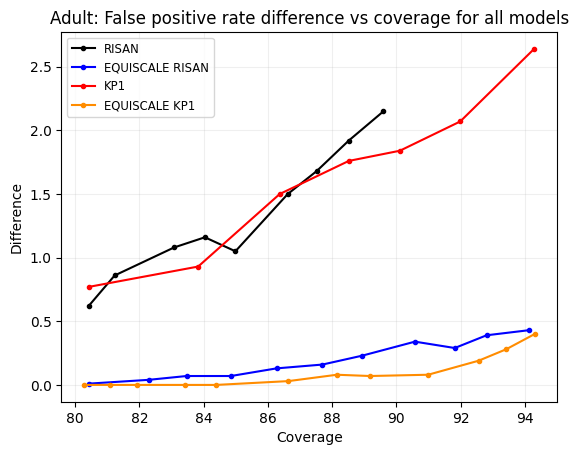

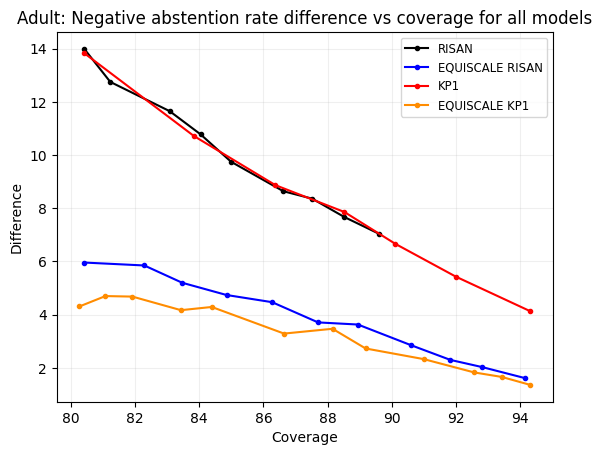

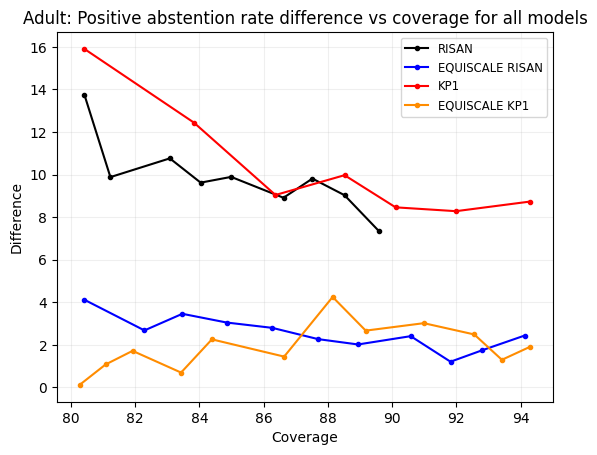

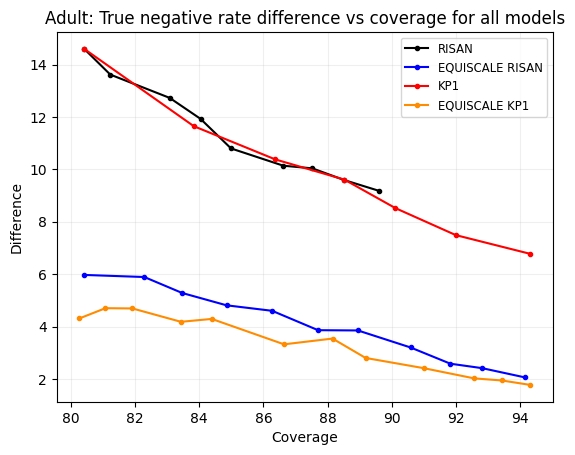

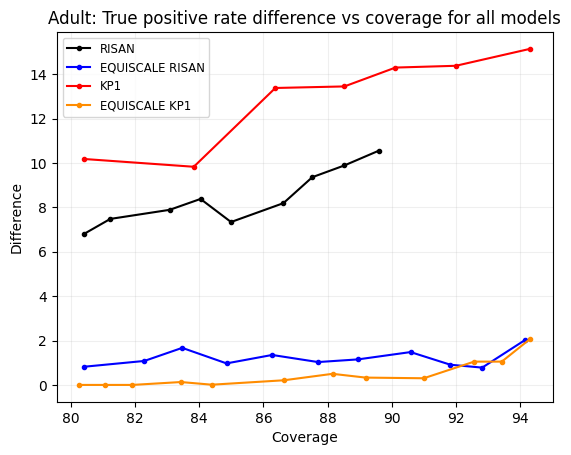

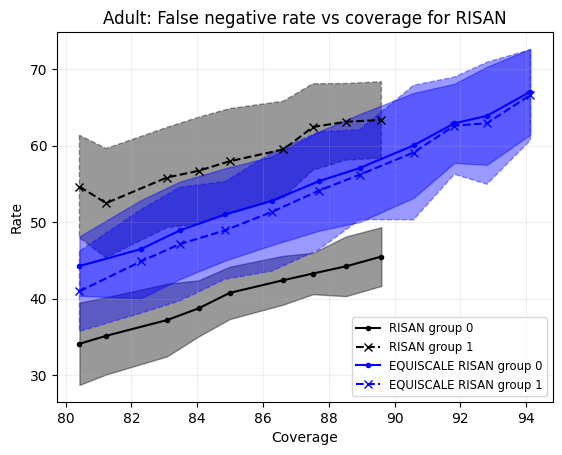

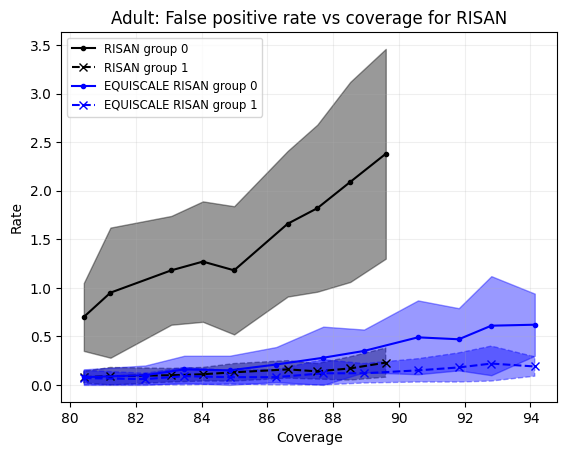

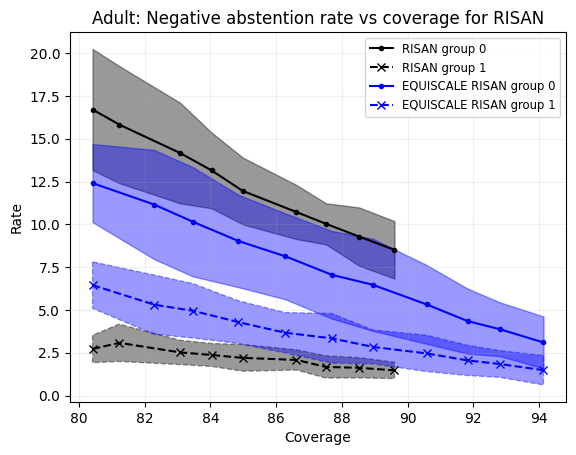

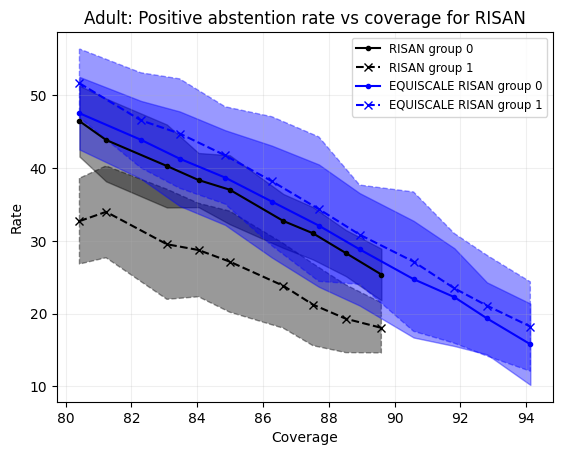

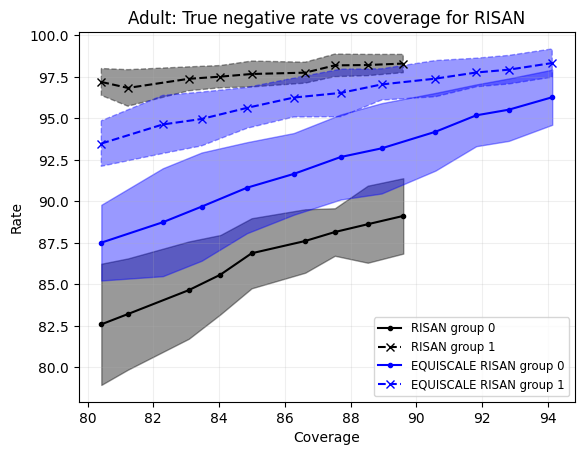

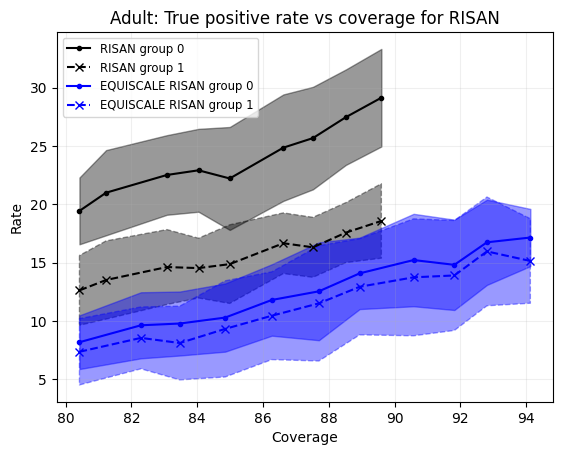

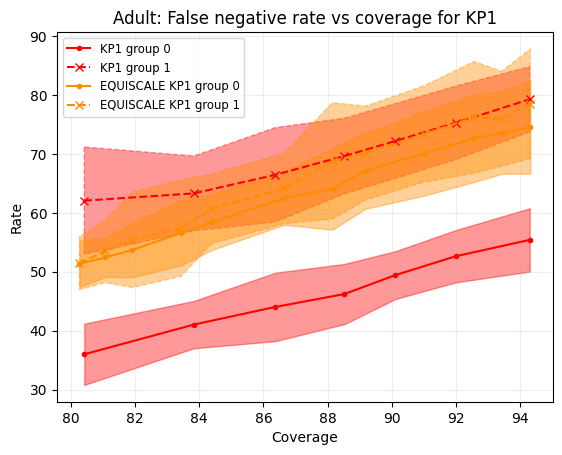

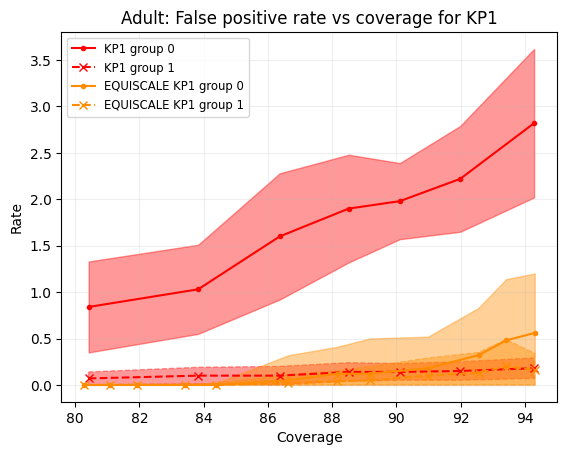

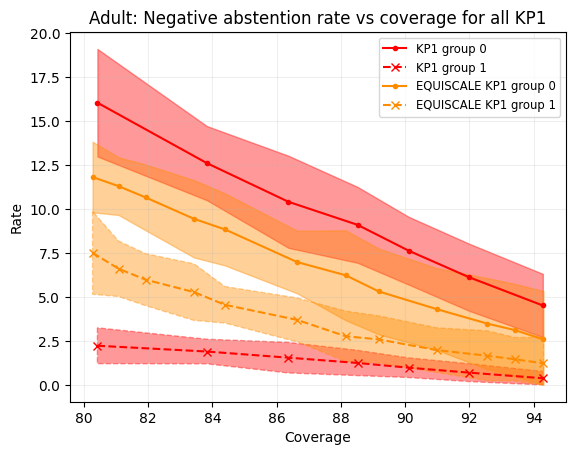

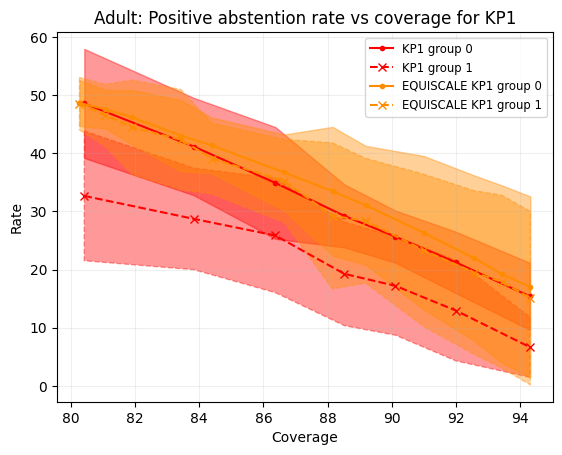

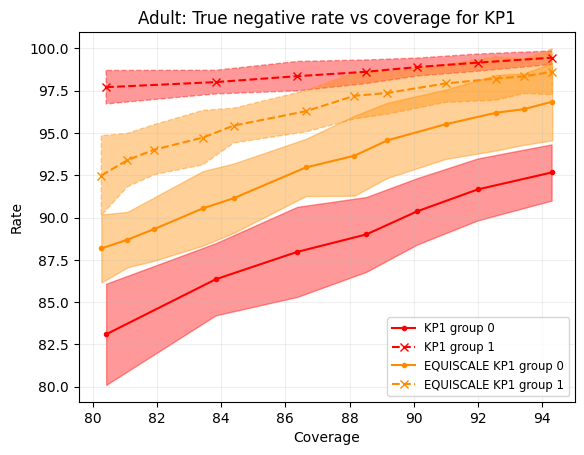

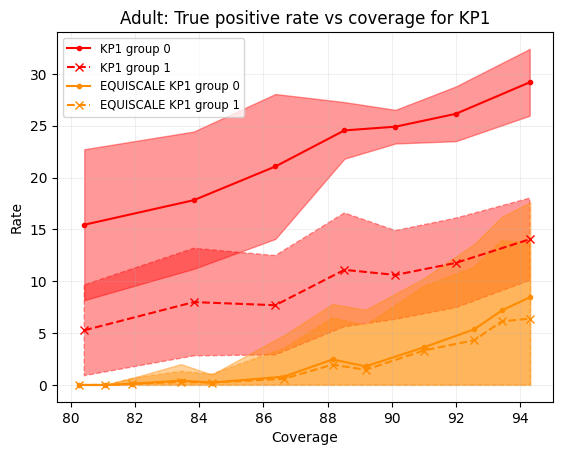

Average violation of fairness constraints
      model    fnr   fpr    nar    par    tnr    tpr
0     risan  18.32  1.34  10.07   9.89  11.40   8.43
1  eq risan   1.36  0.20   3.85   2.56   4.05   1.20
2       kp1  23.36  1.64   8.22  10.40   9.86  12.95
3    eq kp1   2.38  0.09   3.23   1.91   3.33   0.47
Median violation of fairness constraints
      model    fnr   fpr   nar   par    tnr    tpr
0     risan  18.00  1.16  9.75  9.81  10.80   8.19
1  eq risan   1.25  0.16  3.71  2.44   3.86   1.08
2       kp1  22.76  1.76  7.86  9.04   9.61  13.45
3    eq kp1   2.30  0.05  3.38  1.82   3.43   0.26
Max violation of fairness constriants
      model    fnr   fpr    nar    par    tnr    tpr
0     risan  20.57  2.15  13.99  13.75  14.60  10.56
1  eq risan   3.30  0.43   5.96   4.12   5.97   2.01
2       kp1  26.08  2.64  13.83  15.90  14.60  15.14
3    eq kp1   4.75  0.40   4.70   4.25   4.70   2.08


In [58]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_acc")
plt.show()


# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "fnr", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_sep_fnr")
# plt.show()

# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "fpr", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_sep_fpr")
# plt.show()

# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "nar", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_sep_nar")
# plt.show()

# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "par", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_sep_par")
# plt.show()

# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "tnr", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_sep_tnr")
# plt.show()

# plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for all models")
# plt.xlabel("Coverage")
# plt.ylabel("Rate")
# plots(dataframes, "tpr", True, True, False)
# plt.grid(alpha=0.2)
# plt.legend(fontsize="small")
# plt.savefig(f"plots/{DATASET}_sep_tpr")
# plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "fnr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_fnr_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "fpr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_fpr_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "nar", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_nar_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "par", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_par_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "tnr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_tnr_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "tpr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_tpr_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "fnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_fnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "fpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_fpr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "nar", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_nar")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "par", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_par")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "tnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_tnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "tpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_tpr")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "fnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_fnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "fpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_fpr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for all KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "nar", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_nar")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "par", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_par")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "tnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_tnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "tpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_tpr")
plt.show()

print("Average violation of fairness constraints")
print_table(dataframes, ["fnr", "fpr", "nar", "par", "tnr", "tpr"], np.average)
print("Median violation of fairness constraints")
print_table(dataframes, ["fnr", "fpr", "nar", "par", "tnr", "tpr"], np.median)
print("Max violation of fairness constriants")
print_table(dataframes, ["fnr", "fpr", "nar", "par", "tnr", "tpr"], np.max)

---

# Mixed section

In [59]:
formatting = {
    "risan ind": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN - DP",
        "alpha": 0.4,
    },
    "risan ind g0": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN - DP group 0",
        "alpha": 0.4,
    },
    "risan ind g1": {
        "color": "black",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN - DP group 1",
        "alpha": 0.4,
    },
    "risan sep": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN - EO",
        "alpha": 0.4,
    },
    "risan sep g0": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN - EO group 0",
        "alpha": 0.4,
    },
    "risan sep g1": {
        "color": "blue",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN - EO group 1",
        "alpha": 0.4,
    },

    "kp1 ind": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 - DP",
        "alpha": 0.4,
    },
    "kp1 ind g0": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 - DP group 0",
        "alpha": 0.4,
    },
    "kp1 ind g1": {
        "color": "red",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 - DP group 1",
        "alpha": 0.4,
    },
    "kp1 sep": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 - EO",
        "alpha": 0.4,
    },
    "kp1 sep g0": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 - EO group 0",
        "alpha": 0.4,
    },
    "kp1 sep g1": {
        "color": "darkorange",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 - EO group 1",
        "alpha": 0.4,
    },
    "dpabst": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "dpabst g0": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "dpabst g1": {
        "color": "green",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },

    "risan mixed": {
        "color": "fuchsia",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN - MIX",
        "alpha": 0.4,
    },
    "risan mixed g0": {
        "color": "fuchsia",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN - MIX group 0",
        "alpha": 0.4,
    },
    "risan mixed g1": {
        "color": "fuchsia",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN - MIX group 1",
        "alpha": 0.4,
    },

    "kp1 mixed": {
        "color": "blueviolet",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 - MIX",
        "alpha": 0.4,
    },
    "kp1 mixed g0": {
        "color": "blueviolet",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 - MIX group 0",
        "alpha": 0.4,
    },
    "kp1 mixed g1": {
        "color": "blueviolet",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 - MIX group 1",
        "alpha": 0.4,
    },
}

In [60]:
# Mixed section
# load dpabst, eq ind, eq sep, and eq mixed

risan_ind_pd = pd.DataFrame()
risan_sep_pd = pd.DataFrame()
risan_mixed_pd = pd.DataFrame()
kp1_ind_pd = pd.DataFrame()
kp1_sep_pd = pd.DataFrame()
kp1_mixed_pd = pd.DataFrame()
dpabst_pd = pd.DataFrame()

for file in glob.glob("results/*.json"):
    args = file.split("_")
    dataset = args[0].split("/")[1]
    if dataset != DATASET:
        continue
    model = args[2]
    fairness_conditions = args[1]
    record = {}
    with open(file, "r") as f:
        data = json.load(f)
    for key in data.keys():
        record[f"{key}_avg"] = round(data[key][0], 2)
        record[f"{key}_std"] = round(data[key][1], 2)
    temp = pd.Series(record).to_frame().T

    if model == "dpabst":
        cov = float(args[3].split(".j")[0])*100
        if cov < COV_CUTOFFS[DATASET][0] or cov > COV_CUTOFFS[DATASET][1]:
            continue
        dpabst_pd = pd.concat([dpabst_pd, temp])
    elif fairness_conditions == "none":
        continue
    elif fairness_conditions == "abs-neg-pos":
        if record["cov_avg"] < COV_CUTOFFS[DATASET][0] or record["cov_avg"] > COV_CUTOFFS[DATASET][1]:
            continue  
        if model == "risan":
            risan_ind_pd = pd.concat([risan_ind_pd, temp])
        else:
            kp1_ind_pd = pd.concat([kp1_ind_pd, temp])
    elif fairness_conditions == "fnr-fpr-nar-par-tnr-tpr":
        if record["cov_avg"] < COV_CUTOFFS[DATASET][0] or record["cov_avg"] > COV_CUTOFFS[DATASET][1]:
            continue  
        if model == "risan":
            risan_sep_pd = pd.concat([risan_sep_pd, temp])
        else:
            kp1_sep_pd = pd.concat([kp1_sep_pd, temp])
    else:
        if record["cov_avg"] < COV_CUTOFFS[DATASET][0] or record["cov_avg"] > COV_CUTOFFS[DATASET][1]:
            continue  
        if model == "risan":
            risan_mixed_pd = pd.concat([risan_mixed_pd, temp])
        else:
            kp1_mixed_pd = pd.concat([kp1_mixed_pd, temp])


dataframes: dict[str, pd.DataFrame] = {
    "risan ind": risan_ind_pd,
    "risan sep": risan_sep_pd,
    "risan mixed": risan_mixed_pd,
    "kp1 ind": kp1_ind_pd,
    "kp1 sep": kp1_sep_pd,
    "kp1 mixed": kp1_mixed_pd,
    "dpabst": dpabst_pd,
}

for key in list(dataframes.keys()):
    if dataframes[key].empty:
        continue
    dataframes[key] = dataframes[key].sort_values(by="cov_avg")
    last_cov_value = None
    mask = []
    for idx, row in dataframes[key].iterrows():
        if last_cov_value is None or row["cov_avg"] - last_cov_value >= 0.8:
            mask.append(True)
            last_cov_value = row["cov_avg"]
        else:
            mask.append(False)
    dataframes[key] = dataframes[key][mask]

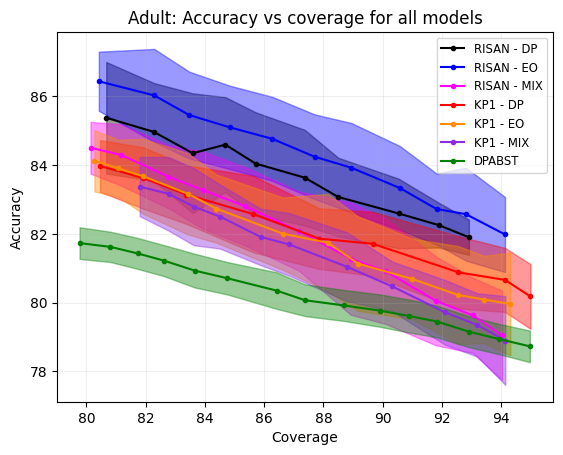

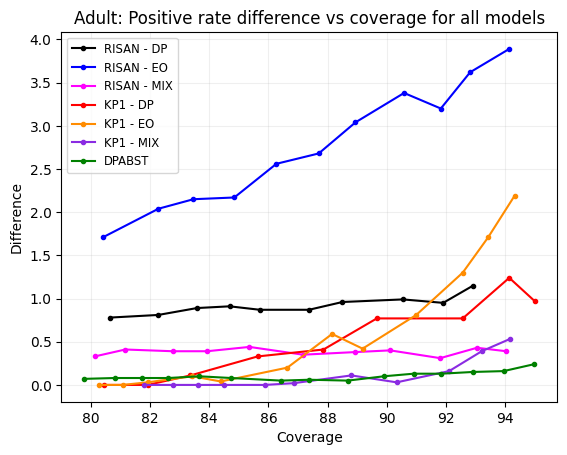

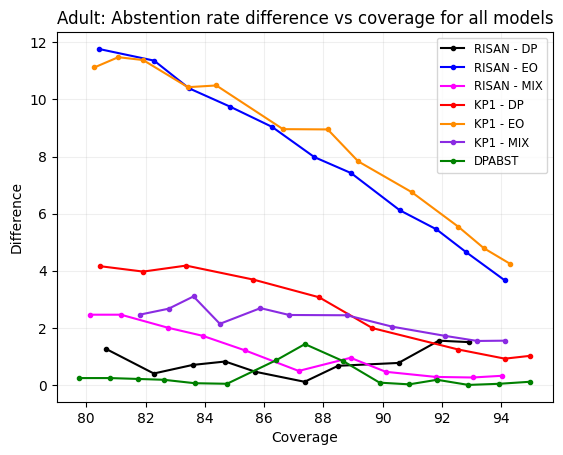

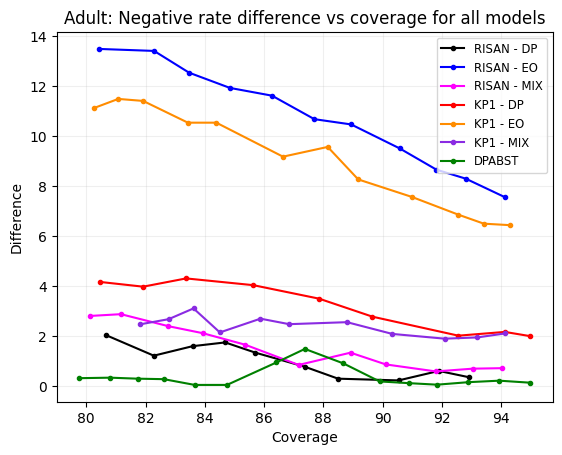

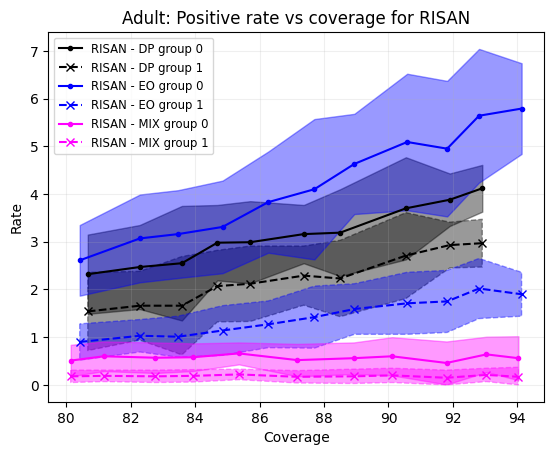

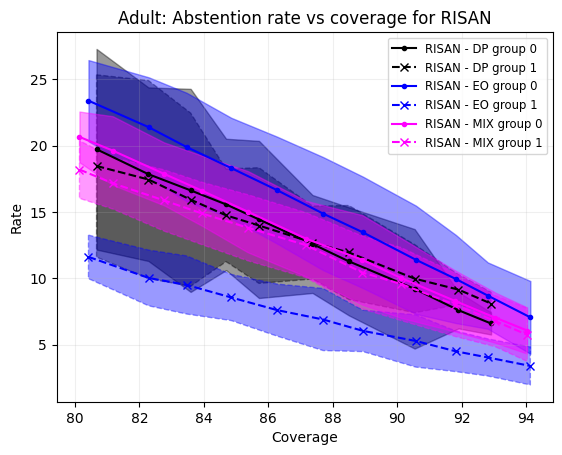

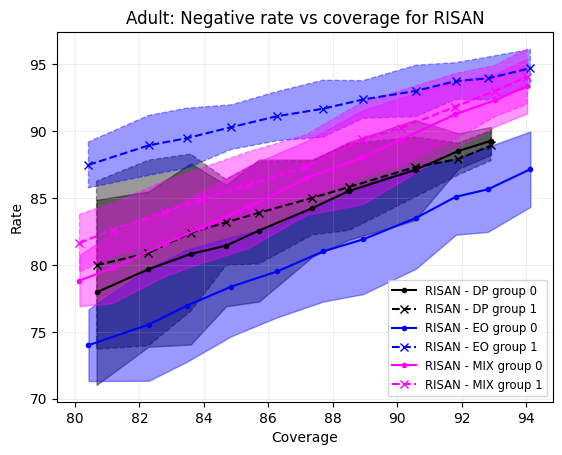

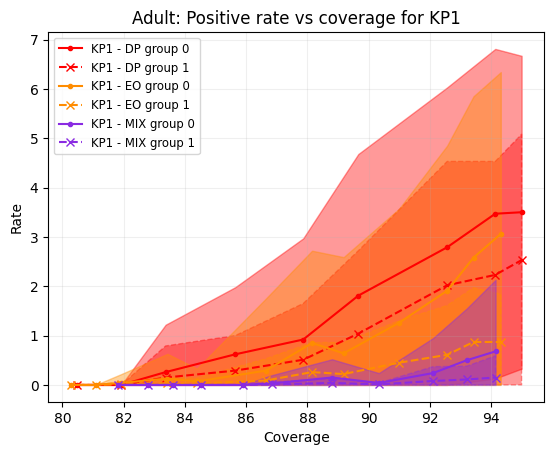

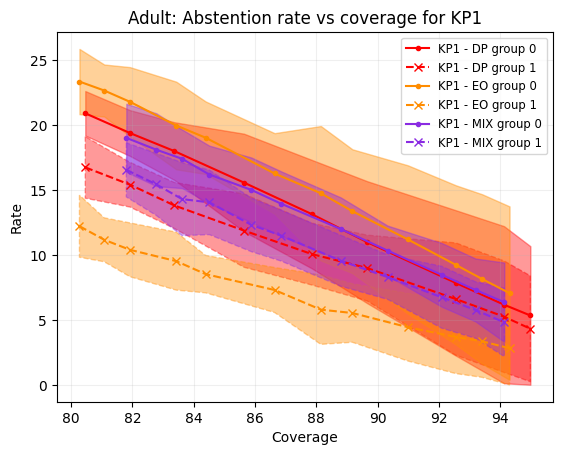

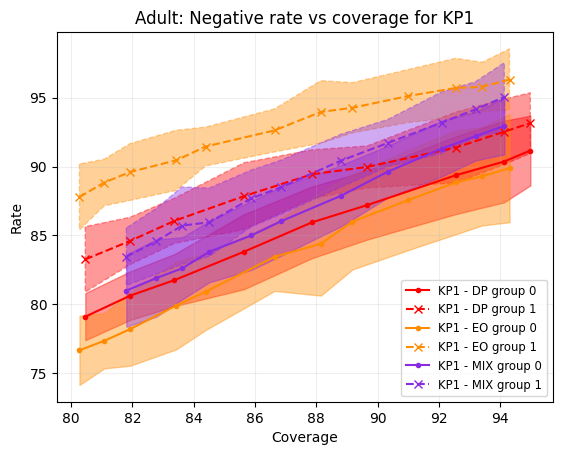

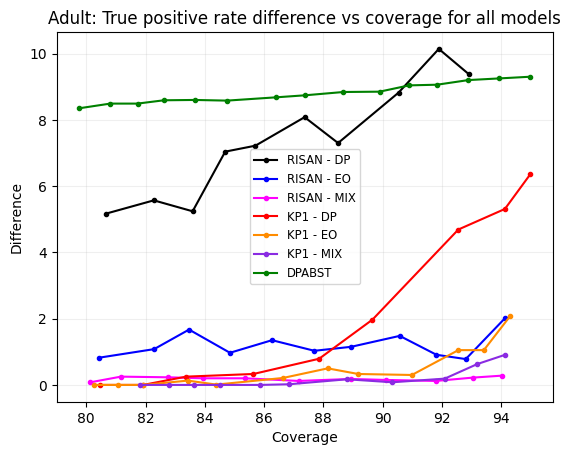

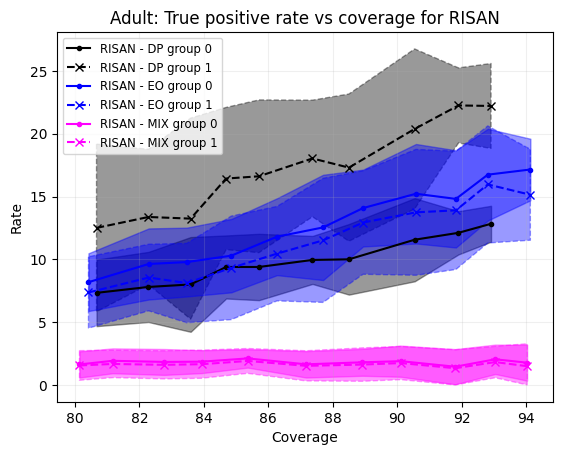

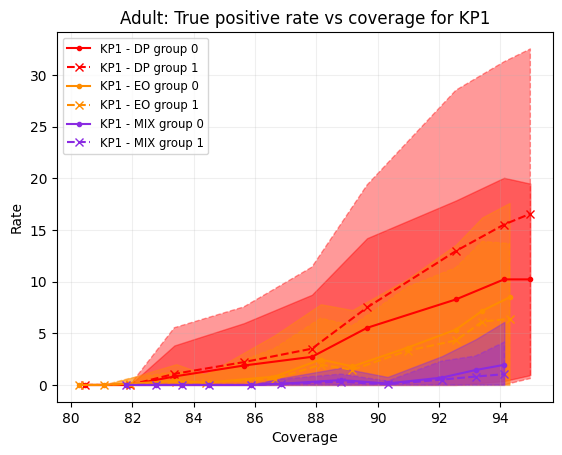

Average violation of fairness constraints
         model   pos    neg   abs   tpr
0    risan ind  0.92   1.01  0.82  7.40
1    risan sep  2.77  10.73  7.96  1.20
2  risan mixed  0.38   1.53  1.15  0.18
3      kp1 ind  0.51   3.21  2.69  2.19
4      kp1 sep  0.62   9.12  8.50  0.47
5    kp1 mixed  0.11   2.37  2.25  0.18
6       dpabst  0.10   0.36  0.30  8.80
Median violation of fairness constraints
         model   pos    neg   abs   tpr
0    risan ind  0.90   0.99  0.73  7.26
1    risan sep  2.68  10.67  7.98  1.08
2  risan mixed  0.39   1.33  0.95  0.20
3      kp1 ind  0.41   3.49  3.07  0.79
4      kp1 sep  0.31   9.36  8.96  0.26
5    kp1 mixed  0.02   2.46  2.44  0.02
6       dpabst  0.08   0.21  0.18  8.74
Max violation of fairness constriants
         model   pos    neg    abs    tpr
0    risan ind  1.15   2.03   1.55  10.14
1    risan sep  3.89  13.48  11.77   2.01
2  risan mixed  0.44   2.87   2.46   0.28
3      kp1 ind  1.24   4.30   4.18   6.36
4      kp1 sep  2.19  11.48  

In [61]:
if DATASET == "adult": # pos, abs, neg, tpr
    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.2)
    plots(dataframes, "acc", True, False, False)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_acc")
    plt.show()

    # plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for all models")
    # plt.xlabel("Coverage")
    # plt.ylabel("Rate")
    # plots(dataframes, "pos", True, True, False)
    # plt.grid(alpha=0.2)
    # plt.legend(fontsize="small")
    # plt.savefig(f"plots/{DATASET}_mixed_pos")
    # plt.show()

    # plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for all models")
    # plt.xlabel("Coverage")
    # plt.ylabel("Rate")
    # plots(dataframes, "abs", True, True, False)
    # plt.grid(alpha=0.2)
    # plt.legend(fontsize="small")
    # plt.savefig(f"plots/{DATASET}_mixed_abs")
    # plt.show()

    # plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for all models")
    # plt.xlabel("Coverage")
    # plt.ylabel("Rate")
    # plots(dataframes, "neg", True, True, False)
    # plt.grid(alpha=0.2)
    # plt.legend(fontsize="small")
    # plt.savefig(f"plots/{DATASET}_mixed_neg")
    # plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plt.grid(alpha=0.2)
    plots(dataframes, "pos", False, False, True)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_pos_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plt.grid(alpha=0.2)
    plots(dataframes, "abs", False, False, True)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_abs_delta")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plt.grid(alpha=0.2)
    plots(dataframes, "neg", False, False, True)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_neg_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_pos")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "abs", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_abs")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "neg", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_neg")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_pos")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "abs", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_abs")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "neg", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_neg")
    plt.show()

    # plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for all models")
    # plt.xlabel("Coverage")
    # plt.ylabel("Rate")
    # plots(dataframes, "tpr", True, True, False)
    # plt.grid(alpha=0.2)
    # plt.legend(fontsize="small")
    # plt.savefig(f"plots/{DATASET}_mixed_tpr")
    # plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plots(dataframes, "tpr", False, False, True)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_tpr_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "tpr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_tpr")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "tpr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_tpr")
    plt.show()

    print("Average violation of fairness constraints")
    print_table(dataframes, ["pos", "neg", "abs", "tpr"], np.average)
    print("Median violation of fairness constraints")
    print_table(dataframes, ["pos", "neg", "abs", "tpr"], np.median)
    print("Max violation of fairness constriants")
    print_table(dataframes, ["pos", "neg", "abs", "tpr"], np.max)